# 一、数据清洗

## 1、载入数据
- data_train = pd.read_csv('./train_data.csv')
- data_test = pd.read_csv('./test_a.csv')

## 2、异常值处理
**丢弃部分异常值：'area' > 200、'tradeMoney' < 700、'tradeMoney' > 16000、'totalFloor' = 0**

## 3、缺失值处理、数据变换
**'rentType' = 无，填充为未知方式**<br>
**'rentType'、'houseFloor'、'houseToward'、'houseDecoration'、'communityName'、'plate'列转换数据类型，使用标签编码**<br>
**将'buildYear'列转换为整型数据**<br>
**将'pv'、'uv'的空值填充为平均值**<br>


## 4、数据深度清洗
- data.drop(data[(data['region']=='RG00001') & (data['tradeMoney']<1000)&(data['area']>50)].index,inplace=True)<br>
- data.drop(data[(data['region']=='RG00001') & (data['tradeMoney']>25000)].index,inplace=True)<br>
......

## 5、特征拆分
**'tradeTime'分割为'month'、'day'**<br>
**'houseType'分割为'Room'、'Hall'、'Bath'**<br>

## 6、交叉生成特征
**'Room'、'Bath'生成'Room_Bath'**<br>

## 7、特征合并 
- data['transportNum'] = 5 * data['subwayStationNum'] / data['subwayStationNum'].mean() + data['busStationNum'] / data['busStationNum'].mean()
- data['all_SchoolNum'] = 2 * data['interSchoolNum'] / data['interSchoolNum'].mean() + data['schoolNum'] / data['schoolNum'].mean() + data['privateSchoolNum'] / data['privateSchoolNum'].mean()
- data['all_hospitalNum'] = 2 * data['hospitalNum'] / data['hospitalNum'].mean() + data['drugStoreNum'] / data['drugStoreNum'].mean()
- data['all_mall'] = data['mallNum'] / data['mallNum'].mean() + data['superMarketNum'] / data['superMarketNum'].mean()
- data['otherNum'] = data['gymNum'] / data['gymNum'].mean() + data['bankNum'] / data['bankNum'].mean() + \data['shopNum'] / data['shopNum'].mean() + 2 * data['parkNum'] / data['parkNum'].mean()<br>
......

## 8、groupby生成统计特征：mean, std等
- temp = data.groupby('plate')['transportNum'].agg('sum').reset_index(name='plate_trainsportNum')
- data = data.merge(temp, on='plate', how='left')
- temp = data.groupby(['communityName', 'plate'])['transportNum'].agg('sum').reset_index(name='com_trainsportNum')
- data = data.merge(temp, on=['communityName', 'plate'], how='left')
- data['trainsportNum_ratio'] = list(map(lambda x, y: round(x / y, 3) if y != 0 else -1,data['com_trainsportNum'],data['plate_trainsportNum']))
- data = data.drop(['com_trainsportNum', 'plate_trainsportNum'], axis=1)<br>
......

# 二、特征选择

### Filter
去掉取值变化小的特征（Removing features with low variance）
单变量特征选择 (Univariate feature selection)
### Wrapper
递归特征消除 (Recursive Feature Elimination)
### Embedding
使用SelectFromModel选择特征 (Feature selection using SelectFromModel)
将特征选择过程融入pipeline (Feature selection as part of a pipeline)

**训练随机森林模型，并通过feature_importances_属性获取每个特征的重要性分数。rf = RandomForestRegressor()**<br>
- from sklearn.ensemble import RandomForestRegressor
- rf = RandomForestRegressor()
- drop_feature = ['rentType', 'newWorkers', 'tradeLandNum', 'tradeLandArea', 'supplyLandArea', 'region', 'landMeanPrice', 'supplyLandNum', 'landTotalPrice']<br>


# 三、模型选择
### lasso、ENet、ridge、KRR、GBoost、xgb、lgb

In [ ]:
kfolds = KFold(n_splits=n_folds, shuffle=True, random_state=42)
alph = [0.01, 0.001, 0.0001, 0.0002, 0.0004, 0.0008, 0.002, 0.004, 0.008, 1, 2, 4, 6, 8, 10, 12]
alph2 = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14]
lasso = make_pipeline(RobustScaler(), LassoCV(alphas=alph, cv=kfolds, random_state=1))
ENet = make_pipeline(RobustScaler(), ElasticNetCV(alphas=alph, l1_ratio=.9, cv=kfolds, random_state=3))
ridge = make_pipeline(RobustScaler(), RidgeCV(alphas=alph2, cv=kfolds))
KRR = KernelRidge(alpha=0.6, kernel='polynomial', degree=2, coef0=2.5)

GBoost = GradientBoostingRegressor(n_estimators=3000, learning_rate=0.05,
                                   max_depth=4, max_features='sqrt',
                                   min_samples_leaf=15, min_samples_split=10,
                                   loss='huber', random_state=5)

model_xgb = xgb.XGBRegressor(colsample_bytree=0.4603, gamma=0.0468,
                             learning_rate=0.05, max_depth=3,
                             min_child_weight=2, n_estimators=2200,
                             reg_alpha=0.4640, reg_lambda=0.8571,
                             subsample=0.5213, silent=True,
                             random_state=7, nthread=-1)

model_lgb = lgb.LGBMRegressor(objective='regression', num_leaves=5,
                              learning_rate=0.05, n_estimators=720,
                              max_bin=55, bagging_fraction=0.8,
                              bagging_freq=5, feature_fraction=0.2319,
                              feature_fraction_seed=9, bagging_seed=9,
                              min_data_in_leaf=6, min_sum_hessian_in_leaf=11)

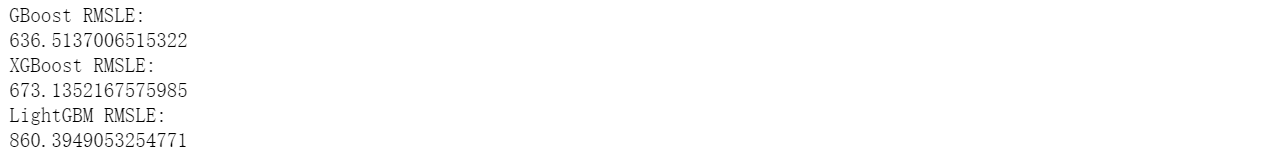

**将特征排序，保留前15个特征，删除无用特征**<br>
- drop_num = 15
- lgb_out = lgb_out[:drop_num]
- xgb_out = xgb_out[:drop_num]
- gbt_out = gbt_out[:drop_num]
- **drop_feature = list(set(lgb_out).union(xgb_out).union(gbt_out))**

# 四、模型融合
### 融合ENet, GBoost, KRR, xgb, lgb模型

- **stacked_averaged_models = StackingCVRegressor(regressors=(ENet, GBoost, KRR), meta_regressor=lasso, use_features_in_secondary=True)**
- stacked_averaged_models.fit(train, y_train)
- stacked_train_pred = stacked_averaged_models.predict(train)
- stacked_pred = np.expm1(stacked_averaged_models.predict(test))
- print('stacked_averaged_models RMSLE:')
- print(rmsle(y_train, stacked_train_pred))<p>

- model_xgb.fit(train, y_train)
- model_lgb.fit(train, y_train)
- xgb_pred = np.expm1(model_xgb.predict(test))
- lgb_pred = np.expm1(model_lgb.predict(test))
- print('0.7stacked + 0.15xgb + 0.15lgb RMSLE:')
- **print(rmsle(y_train, stacked_train_pred * 0.7 + xgb_train_pred * 0.15 + lgb_train_pred * 0.15))**